In [65]:
# All imports moved to the top for clarity and reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
import pickle
from collections import Counter

# Spam Detection End-to-End Workflow

This notebook demonstrates the full workflow for spam detection, including data loading, preprocessing, model training, evaluation, and prediction.

In [66]:
# Load the new, larger dataset for training
# Replace 'spam.csv' with your new dataset filename, e.g., '190k_mails_spam.csv'
df = pd.read_csv('190k_mails_spam.csv', encoding='utf-8', on_bad_lines='skip')

## Data Cleaning

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [68]:
# # since last 3 columns are redundant, we drop them
# df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [ ]:
df.rename(columns = {'label':'target'}, inplace = True)
df.sample(5)

,target,text
41827,Spam,bullish report target sym bvyhprice current es...
117057,Ham,hi dear r users i have a file text nommed chif...
72315,Ham,start date : 1 / 3 / 02 ; hourahead hour : 15 ...
100400,Ham,on escapenumber escapenumber escapenumber waic...
54053,Ham,the tw presentations have been posted to tw do...


In [70]:
encoder = LabelEncoder()

In [71]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
78287,0,john appreciate allowing us use enclosed offic...
137241,0,please note master workplan updated please rev...
19227,0,marie the counterparty states that the coverag...
54011,0,line company from enron\nthanks for the note ....
33878,0,looks like right cnr mar escapenumber fix tab ...


In [72]:
df.duplicated().sum()

np.int64(0)

In [73]:
df =df.drop_duplicates(keep='first')

In [74]:
df.shape

(193852, 2)

In [75]:
df['target'].value_counts()

target
0    102160
1     91692
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x24a3f812990>,
 [Text(-0.09319338334040862, 1.0960451602473176, 'ham'),
  Text(0.09319360981848643, -1.0960451409905525, 'spam')],
 [Text(-0.05083275454931379, 0.5978428146803549, '52.70'),
  Text(0.05083287808281077, -0.5978428041766649, '47.30')])

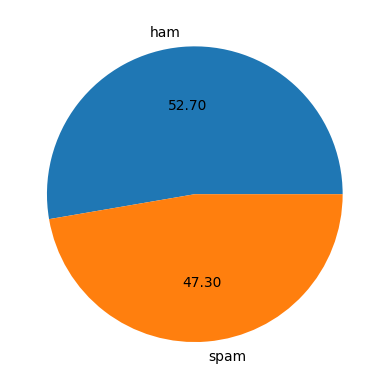

In [76]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')

In [77]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
df['num_characters'] = df['text'].fillna('').apply(len)

In [80]:
df.head()

,target,text,num_characters
0,1,viiiiiiagraaaa\nonly for the ones that want to...,403
1,0,got ice thought look az original message ice o...,530
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,215
3,1,start increasing your odds of success & live s...,345
4,0,author jra date escapenumber escapenumber esca...,3097


In [82]:
df['num_words'] = df['text'].fillna('').apply(lambda x: len(nltk.word_tokenize(x)))


In [83]:
df['num_sentences'] = df['text'].fillna('').apply(lambda x:len(nltk.sent_tokenize(x)))

In [84]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,1,viiiiiiagraaaa\nonly for the ones that want to...,403,60,5
1,0,got ice thought look az original message ice o...,530,60,1
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,215,48,1
3,1,start increasing your odds of success & live s...,345,69,8
4,0,author jra date escapenumber escapenumber esca...,3097,468,1


In [85]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1.938520e+05,1.938520e+05,193852.000000
mean,1.812761e+03,2.780963e+02,3.690470
std,2.659496e+04,3.672818e+03,23.062132
min,0.000000e+00,0.000000e+00,0.000000
25%,3.620000e+02,5.600000e+01,1.000000
50%,8.000000e+02,1.280000e+02,1.000000
75%,1.803000e+03,2.820000e+02,1.000000
max,1.151031e+07,1.585483e+06,3093.000000


In [86]:
df[df['target']==0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1.021600e+05,1.021600e+05,102160.000000
mean,2.169702e+03,3.368361e+02,3.762294
std,3.656247e+04,5.048335e+03,26.428314
min,0.000000e+00,0.000000e+00,0.000000
25%,4.170000e+02,6.500000e+01,1.000000
50%,9.500000e+02,1.500000e+02,1.000000
75%,1.968000e+03,3.130000e+02,1.000000
max,1.151031e+07,1.585483e+06,2827.000000


In [87]:
df[df['target']==1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,91692.000000,91692.000000,91692.000000
mean,1415.069679,212.650428,3.610446
std,2367.960966,340.551478,18.607589
min,0.000000,0.000000,0.000000
25%,309.000000,48.000000,1.000000
50%,675.000000,107.000000,1.000000
75%,1570.000000,241.000000,1.000000
max,144087.000000,25444.000000,3093.000000


<Axes: xlabel='num_characters', ylabel='Count'>

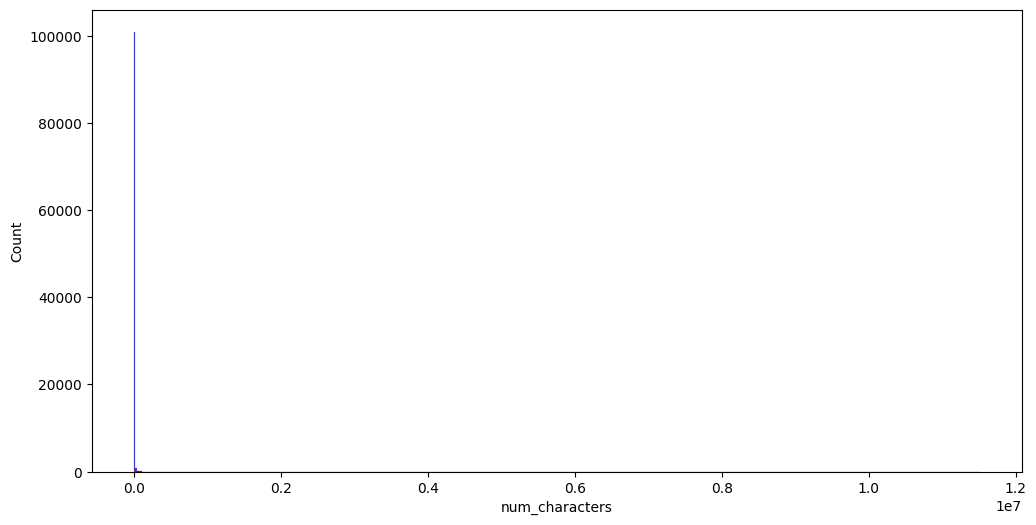

In [88]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['num_characters'], color='blue', label='ham')
sns.histplot(df[df['target']==1]['num_characters'], color='red')

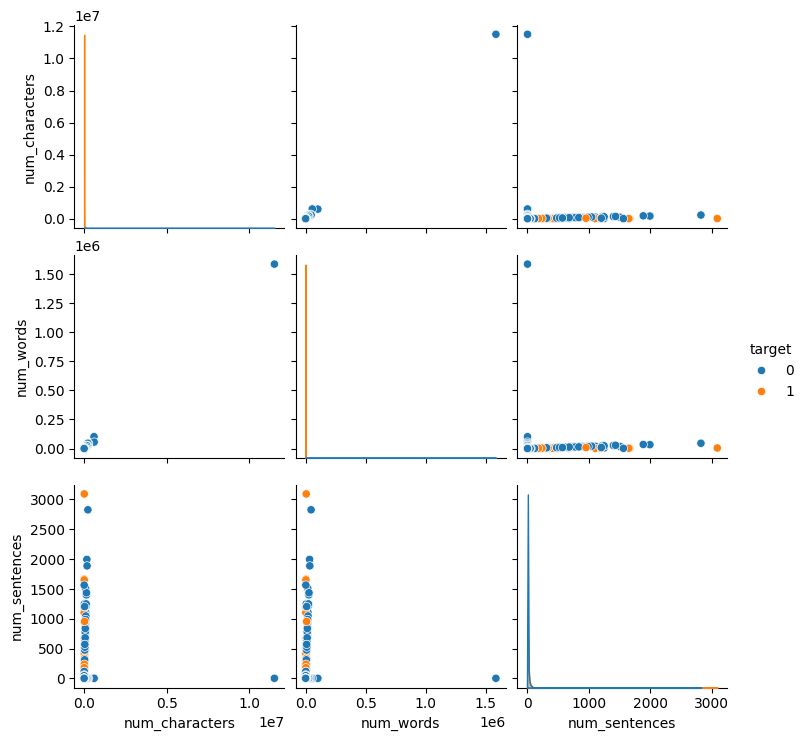

In [89]:
sns.pairplot(df,hue='target')

<Axes: >

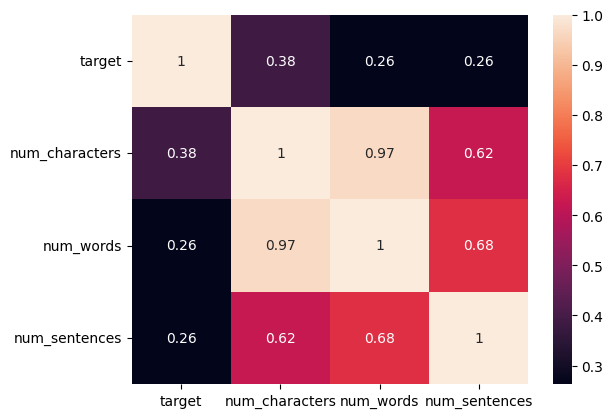

In [ ]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)

**Data Processing**
- Lowercase
- Tokenize
- Remove Special chars
- Removing stop words and punctuation
- Stemming

In [90]:
stopwords.words('english')
string.punctuation
stemmer = PorterStemmer() 

In [91]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(stemmer.stem(i))
    return " ".join(y)

In [ ]:
transform_text('Hey i just saw your project you have been working on. I love it!')

'hey saw project work love'

In [93]:
df['transformed_text'] = df['text'].fillna('').astype(str).apply(transform_text)
df.head()

KeyboardInterrupt: 

In [ ]:
spam_corpus = []
for message in df[df['target']==1]['transformed_text'].to_list():
    for word in message.split():
        spam_corpus.append(word)

ham_corpus = []
for message in df[df['target']==0]['transformed_text'].to_list():
    for word in message.split():
        ham_corpus.append(word)

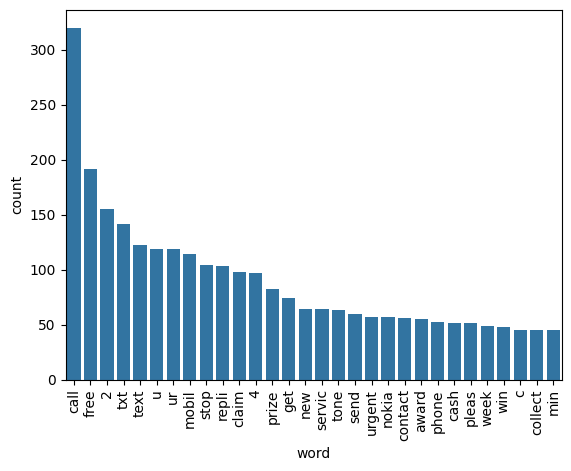

In [ ]:
common_words = Counter(spam_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()


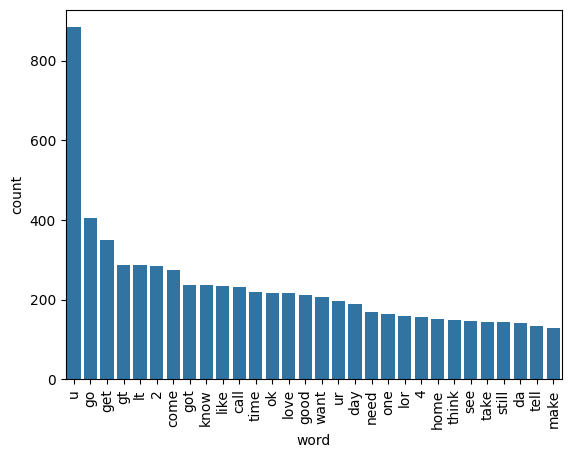

In [ ]:
# Visualizing the most common words in spam messages
common_words = Counter(ham_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()

**Model Building**

In [ ]:
tfidf = TfidfVectorizer()
cv = CountVectorizer()

In [ ]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

- Applying train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Initializing various classifiers
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [ ]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [ ]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [ ]:
# --- Model Training Section ---
# Train all models in one place for clarity

# Prepare features and labels
vectorizer = TfidfVectorizer(max_features=2000, min_df=2, max_df=0.9, ngram_range=(1,2))
X = vectorizer.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Define classifiers
clfs = {
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1'),
    'SVC': SVC(kernel='sigmoid', gamma=1.0),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=2),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=2),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=2),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=50, random_state=2),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'MultinomialNB': MultinomialNB(alpha=2.0),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB()
}

# Train and store results
results = []
for name, clf in clfs.items():
    if name == 'GaussianNB':
        # GaussianNB does not support sparse input
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec})
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}")

LogisticRegression - Accuracy: 0.9574, Precision: 0.9434
SVC - Accuracy: 0.9758, Precision: 0.9669
SVC - Accuracy: 0.9758, Precision: 0.9669
KNeighbors - Accuracy: 0.9168, Precision: 1.0000
KNeighbors - Accuracy: 0.9168, Precision: 1.0000
DecisionTree - Accuracy: 0.9333, Precision: 0.8632
DecisionTree - Accuracy: 0.9333, Precision: 0.8632
RandomForest - Accuracy: 0.9749, Precision: 0.9746
RandomForest - Accuracy: 0.9749, Precision: 0.9746
AdaBoost - Accuracy: 0.9217, Precision: 0.8519
AdaBoost - Accuracy: 0.9217, Precision: 0.8519
Bagging - Accuracy: 0.9613, Precision: 0.9083
Bagging - Accuracy: 0.9613, Precision: 0.9083
ExtraTrees - Accuracy: 0.9778, Precision: 0.9832
ExtraTrees - Accuracy: 0.9778, Precision: 0.9832
GradientBoosting - Accuracy: 0.9526, Precision: 0.9320
MultinomialNB - Accuracy: 0.9671, Precision: 1.0000
GaussianNB - Accuracy: 0.8636, Precision: 0.4939
GradientBoosting - Accuracy: 0.9526, Precision: 0.9320
MultinomialNB - Accuracy: 0.9671, Precision: 1.0000
GaussianNB

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [ ]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [ ]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)


,estimators,"[('svm', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [ ]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9806576402321083
Precision 0.9916666666666667


In [ ]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9806576402321083
Precision 0.9609375


In [ ]:
import pickle
# Export all relevant models
pickle.dump(tfidf, open('vectorizer.pkl','wb'))
pickle.dump(mnb, open('model_mnb.pkl','wb'))
pickle.dump(voting, open('model_voting.pkl','wb'))
pickle.dump(clf, open('model_stacking.pkl','wb'))
pickle.dump(transform_text, open('transform_text.pkl', 'wb'))